In [1]:
%load_ext autoreload
%autoreload 1
import scipy.io as io
import matplotlib.pyplot as plt
from matplotlib import animation
from celluloid import Camera
import numpy as np
import numpy as np
from itertools import product
import os
from model.ExtendedTSSRP import ExtendedTSSRP
from model.TSSRP import TSSRP
from model.MSSRP import MSSRP
# from adaptCUSUM import AdaptCUSUM
from spc import spc
import time
import pickle

# Load Data

In [2]:
data = io.loadmat('data/temperature.mat')
X_org = data['mMov0']
X = data['mMov1']
X = np.rollaxis(X,2,0)
X_org = np.rollaxis(X_org,2,0)
X = X*14 
X = X - np.mean(X)
X.shape
nt,nx,ny = X.shape

### Figure 1

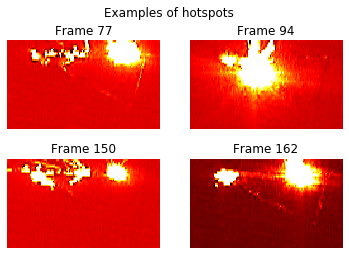

In [3]:
fig=plt.figure()
hotspots = [77, 94, 150, 162]
for i in range(1,5):
    ax=fig.add_subplot(2,2,i)        
    ax.imshow(X_org[hotspots[i-1]-1],cmap=plt.get_cmap('hot'))
    ax.set_title('Frame {}'.format(hotspots[i-1]))
    ax.axis('off')
fig.suptitle('Examples of hotspots') # or plt.suptitle('Main title')
plt.show()

# Data Preprocessing

## Find the printing regions from the dataset 

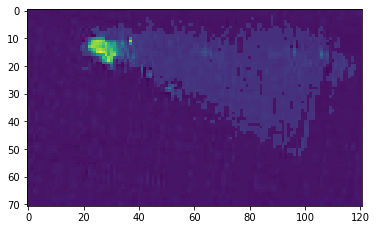

In [4]:
printingregion = np.sum(X_org,0)>30
defectregion = X[-100]
plt.imshow(printingregion+defectregion)

## Find the failure mode $M$ for that overlaps with the printing regions

In [5]:
kx = 20
ky = 30
degree = 2 # Overlap region? (Size of B-spline basis) 
Bx = bsplineBasis(nx,kx-degree+1,degree)
By = bsplineBasis(ny,ky-degree+1,degree)
Mall = np.kron(Bx,By)

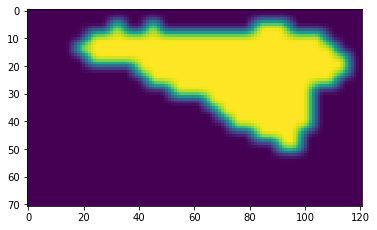

In [6]:
ii = []
MMregion = 0
for i in np.arange(Mall.shape[1]):
    mM = Mall[:,i].reshape(nx,ny)
    mMregion = mM > 0.1
    res = np.logical_and(mMregion,printingregion)
    if np.sum(res[:]) > 20:
        ii.append(i) 
        MMregion = MMregion + mM
M = Mall[:,ii]
plt.imshow(MMregion)

# Create model instance

In [7]:
p = nx*ny # Number of dimensions
c = 20 # Target meanshift is c * M
nsensors = 200 # Number of selected sensors
Ks = 25  #Select Top Ks control chart
k = M.shape[1]
T0 = 70
nmodels = 5
M_tssrp = np.kron(np.eye(p),np.ones((1,1))) # Mean Failure Modes
experiment_log = {'c':c, 'Ks':Ks, 'k0':k, 'degree':degree,'statistics':[],
                  'sens_history': [],
                  'mode_history':[],
                  'seq_stats': [] }
model_all = [[] for i in range(nmodels)]
model_all[0] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'srp',mode='T2',overflow=True)
model_all[1] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'srp',mode='random')
model_all[2] = ExtendedTSSRP(p, c, k,M,p,Ks,L=-1,chart = 'srp',mode='T2')
model_all[3] = TSSRP(p, c, p,M_tssrp,nsensors,nsensors,L=-1,chart='srp',mode='T2')
model_all[4] = MSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T2')

mumin = 1
#model_all[4]= AdaptCUSUM(p, c, p, M, nsensors, nsensors, mumin = mumin,delta=0.0002

# Run Experiment

MTSSRP
32.85763502120972


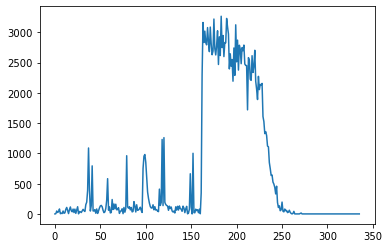

In [8]:
import time
start = time.time()
modelname = ['MTSSRP','Random','Oracle','TSSRP','AdaCUSUM']
# for i in range(nmodels):
for i in [0]:
    print(modelname[i])
    sequential_statistics_topRsum, sensor_selection_history, failure_mode_history, i,sequential_statistics= model_all[i].compute_monitoring_statistics(X.reshape((nt,nx*ny)),T0,-1)
    experiment_log['statistics'].append( sequential_statistics_topRsum)
    experiment_log['sens_history'].append(sensor_selection_history)
    experiment_log['mode_history'].append(failure_mode_history)
    experiment_log['seq_stats'].append(sequential_statistics)
    plt.figure()
    plt.plot(sequential_statistics_topRsum)
    
end = time.time()
print(end - start)

In [ ]:
fig, axes = plt.subplots(2,2)
camera = Camera(fig)
for t in range(250):
    axes[0,0].imshow(X[t],cmap=plt.get_cmap('hot'))
    axes[0,0].set_yticks([])
    axes[0,0].set_xticks([])
    axes[0,1].plot(sequential_statistics_topRsum[:t],'k-')
    axes[0,1].set(xlim=(0, nt), ylim=(0, 3000))
    axes[0,1].set_yticks([])
    axes[1,0].set_yticks([])
    S = np.zeros((nx*ny))
    S[sensor_selection_history[t].astype(int)] = 1
    mS = S.reshape(nx,ny)
    axes[1,0].imshow(mS,cmap=plt.get_cmap('hot'))

    axes[1,1].imshow(np.sum(M[:,failure_mode_history[t,0:10].astype(int)],axis=1).reshape(nx,ny))
    camera.snap()
animation = camera.animate()
animation.save('result/3D_original.mp4')

In [ ]:
from IPython.display import Video

Video("3D_original.mp4",embed=True, width=640, height=320)

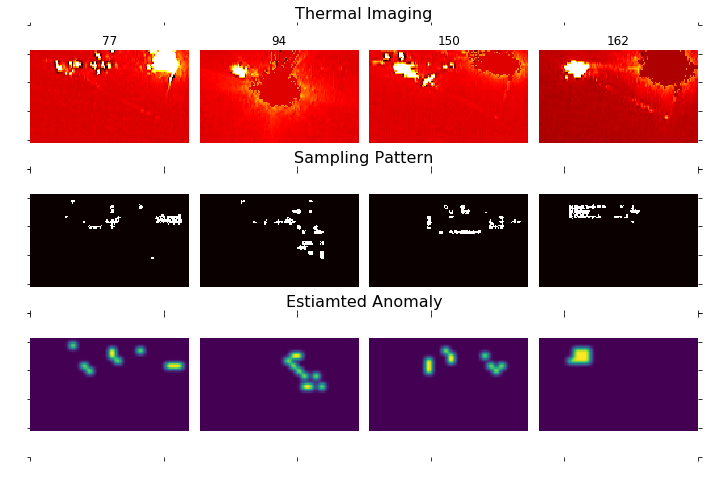

In [11]:
fig, big_axes = plt.subplots( figsize=(10, 10) , nrows=3, ncols=1, sharey=True) 

row_name = ['Thermal Imaging', 'Sampling Pattern', 'Estiamted Anomaly']
i = 0
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(row_name[i], fontsize=16)

    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
    i += 1

col_name = [77, 94, 150, 162]
for i in range(4):
    t = col_name[i]
    ax = fig.add_subplot(3,4,1+i)
    ax.set_title(str(t))
    ax.imshow(X[t],cmap=plt.get_cmap('hot'))
    ax.axis('off')
    ax = fig.add_subplot(3,4,5+i)
    
    S = np.zeros((nx*ny))
    S[sensor_selection_history[t].astype(int)] = 1
    mS = S.reshape(nx,ny)
    ax.imshow(mS,cmap=plt.get_cmap('hot'))
    ax.axis('off')
    ax = fig.add_subplot(3,4,9+i)
   
    ax.imshow(np.sum(M[:,failure_mode_history[t,0:10].astype(int)],axis=1).reshape(nx,ny))
    ax.axis('off')
fig.set_facecolor('w')
plt.tight_layout()

plt.subplots_adjust(bottom=0.3, top=0.9, hspace=0)

# plt.savefig('figs/case_3d.eps')

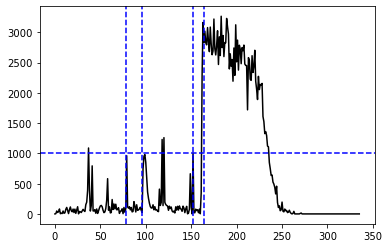

In [12]:
plt.plot(sequential_statistics_topRsum,'k-')
plt.axvline(x=78, color='b', linestyle='--')
plt.axvline(x=96, color='b', linestyle='--')
plt.axvline(x=152, color='b', linestyle='--')
plt.axvline(x=164, color='b', linestyle='--')
plt.axhline(y=1000, color='b', linestyle='--')